# ゼロから始める簡単NNP

## NNPとは？？
Neural Network Potentialの略です。原子構造の情報を受け取って、エネルギーの値を予測する、ニューラルネットワークベースの機械学習モデルです。第一原理計算での構造とエネルギーの関係を再現するように、第一原理計算結果を使って学習させる仕組みを使っています。

この最も単純なケースを試してみましょう。今回扱うのは、結晶Siです。分子動力学法のトラジェクトリーを使って、様々な温度での熱ゆらぎが加わっていたり、密度が異なった状態での1250パターンの構造とエネルギーの情報を集めてあるので、それを学習データにします。

## 対称性関数の計算結果のロード
構造とエネルギーの関係を学ばせるにあたって、まず構造をニューラルネットワーク的に扱いやすいデータに変換する必要があります。
その方法の一つが対称性関数です。

対称性関数の説明や計算は別のファイルにまとめているので、そちらを見てください。
https://github.com/eminamitani/sample_NNP/blob/main/make_desc.ipynb

今回は時間短縮のため保存しておいたデータを使います。

In [3]:
import numpy as np
desc=np.load('desc.npy')
label=np.load('label.npy')

In [4]:
desc.shape

(1250, 64, 11)

データがどんな形か確認してみましょう。descは計算された対称性関数の11の値（最初の値は、G0と表記されるシンプルな動径分布に対応します）を保持していて、labelは系の原子あたりの平均エネルギーの情報を持っています。(全エネルギーそのままだと値が大きすぎるので)

In [5]:
desc[0,0,:], label[0]

(array([13.571609  ,  9.172703  ,  6.4423614 ,  3.4930756 ,  1.3537661 ,
         0.35307807,  0.03834928,  0.7360559 ,  0.43611127,  0.28210217,
         0.05149077], dtype=float32),
 -5.8122244)

In [6]:
desc[1,0,:], label[1]

(array([14.427327  ,  9.910984  ,  7.078461  ,  3.9639223 ,  1.6263943 ,
         0.4749474 ,  0.06694016,  1.0451641 ,  0.593504  ,  0.4443306 ,
         0.08542389], dtype=float32),
 -5.812823)

対称性関数の値にもそれなりにばらつきがありそうです。

ニューラルネットワークの実装では配列の形を勘違いしてミスをすることが多いので確認しておきます

In [7]:
desc.shape, label.shape

((1250, 64, 11), (1250,))

本当はデータを正規化したほうが良いのですが、ひとまず単純に処理してみましょう

 ## ニューラルネットワークの定義
 今回は、ニューラルネットワークというと真っ先にイメージされる多層パーセプトロンを使います。

 このモデルでは、11の対称性関数の値を受け取って、それをノード数20の隠れ層に渡し、最終的に一つの出力を得る形になっています。
 この出力は「原子ひとつあたりのエネルギー」に相当すると考えます。原子ひとつあたりのエネルギーがきちんと定義できるのかはさておき、それらを足し上げると、系の全エネルギーになるようにネットワーク中の重みやバイアスを最適化していきます。

In [8]:
import torch.nn as nn
import torch
import torch.optim as optim

class Net(nn.Module):
    #n_sf : number of symmetry function
    #two-hidden layer
    #output is energy per atom
    def __init__(self,n_sf,n_hidden):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(n_sf, n_hidden)
        self.a1  = nn.Tanh()
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.a2  = nn.Tanh()
        self.fc3 = nn.Linear(n_hidden,1)

        #for debug backprop
        self.fc1mask=[]
        self.fc2mask=[]

        #He initialization
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc3.weight)
        self.results={}

        self.layers=[self.fc1, self.a1, self.fc2, self.a2, self.fc3]

    #relu actination function
    #two hidden layer
    #evaluate eneergy & derivative in forward run
    def forward(self,x):

        for layer in self.layers:
            x=layer(x)

        return x

## 学習データとテストデータの分割
機械学習では過学習（使ったデータにはよく合うが、それ以外のデータにはうまく対応できない）がつきものなので、汎化性能を調べるために、学習データとテストデータの分割を行います。今回は8割を学習データ、2割をテストデータにします。

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(desc, label, test_size=0.2)

pytorchはテンソルを入力として受け取り、出力もテンソルにすることができます。上記の`Net`クラスで実装されているモデルはベクトルを受け取ることを前提にかかれていますが、それが積み上がってテンソルになった入力に対しても柔軟に処理することができます。イメージ的に分かりにくいので、実際にやってみましょう。

In [10]:
#データ処理の概要確認
#テンソルとしてデータを一気に流し込み、原子数の次元で和を取る
nacsf=11
model=Net(n_sf=nacsf,n_hidden=20)
test_out=model(torch.tensor(X_train))
test_out.shape

torch.Size([1000, 64, 1])

1000データがあって、それぞれに（64,1）の配列が格納されている形式になっています。この64というのは原子数で、実際の正解データと比較するのは、64原子分の総和をとった値です。それは以下のようにして計算できます。

In [11]:
p_energy=torch.sum(test_out, dim=1)
p_energy.shape


torch.Size([1000, 1])

## データローダーの定義
効率よく学習させるためにはミニバッチ学習が欠かせません。というわけで、そのためのデータローダーを組みます

torchのtensor型に変換します。y_train, y_testはモデルの出力と整合させるために、unsqueeze(1)で余分な次元をつけています

In [12]:
X_train=torch.tensor(X_train)
X_test=torch.tensor(X_test)
y_train=torch.tensor(y_train).unsqueeze(1)
y_test=torch.tensor(y_test).unsqueeze(1)

In [13]:
#define dataset
train_dset=[(data,label) for data, label in zip(X_train, y_train)]
test_dset=[(data,label) for data, label in zip(X_test, y_test)]
nbatch=100
train_loader =torch.utils.data.DataLoader(train_dset, batch_size=nbatch, shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dset, batch_size=nbatch, shuffle=True)

## 学習部分のコード

ログ取得

In [14]:
from torch.utils.tensorboard import SummaryWriter
import os
import datetime
dir=os.path.join("./logs", datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
writer = SummaryWriter(log_dir=dir)

学習＆テスト結果のループ部分

In [15]:

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, test_loader):
    for epoch in range(1, n_epochs+1):
        loss_t=0.0
        loss_v=0.0
        for train, train_labels in train_loader:
            tmp=model(train)
            p_train=torch.sum(tmp, dim=1)/64.0

            loss_train=loss_fn(p_train, train_labels)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            loss_t+=loss_train.item()

        #validation
        with torch.no_grad():
            for val, val_labels in test_loader:
                p_val= torch.sum(model(val),dim=1)/64.0
                loss_val=loss_fn(p_val, val_labels)
                loss_v+=loss_val.item()
        
        writer.add_scalar("loss_train", loss_t/len(train_loader), epoch)  
        writer.add_scalar("loss_val", loss_v/len(test_loader), epoch)  
        
        if epoch == 1 or epoch %100 ==0:
            print('Epoch %d, Training Loss %f' %(epoch, loss_t/len(train_loader)))
            print('\t Validation Loss %f' %(loss_v/len(test_loader)))
    
    writer.close()
    return 

In [16]:
optimizer=optim.Adam(model.parameters(), lr=0.001)

In [17]:
training_loop(n_epochs=5000, optimizer=optimizer,model=model,
             loss_fn=nn.MSELoss(), train_loader=train_loader, test_loader=test_loader)

Epoch 1, Training Loss 45.155489
	 Validation Loss 38.955563
Epoch 100, Training Loss 0.003835
	 Validation Loss 0.003426
Epoch 200, Training Loss 0.003777
	 Validation Loss 0.003482
Epoch 300, Training Loss 0.003727
	 Validation Loss 0.003603
Epoch 400, Training Loss 0.003623
	 Validation Loss 0.003594
Epoch 500, Training Loss 0.003553
	 Validation Loss 0.003468
Epoch 600, Training Loss 0.003282
	 Validation Loss 0.003301
Epoch 700, Training Loss 0.002951
	 Validation Loss 0.002848
Epoch 800, Training Loss 0.002725
	 Validation Loss 0.002819
Epoch 900, Training Loss 0.002382
	 Validation Loss 0.002229
Epoch 1000, Training Loss 0.001879
	 Validation Loss 0.001996
Epoch 1100, Training Loss 0.001345
	 Validation Loss 0.001313
Epoch 1200, Training Loss 0.000849
	 Validation Loss 0.000907
Epoch 1300, Training Loss 0.000670
	 Validation Loss 0.000579
Epoch 1400, Training Loss 0.000590
	 Validation Loss 0.000522
Epoch 1500, Training Loss 0.000542
	 Validation Loss 0.000460
Epoch 1600, Traini

正解と予測結果をプロットしてみましょう

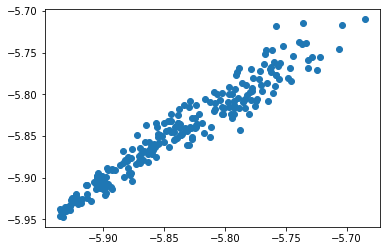

In [18]:
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    predict=torch.sum(model(X_test),dim=1)/64.0
    #plt.xlim((-6,-5.6))
    #plt.ylim((-6,-5.6))
    plt.scatter(y_test,predict)